In [1]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats

'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

In [2]:
building = pd.read_csv('./data/building_metadata.csv')
weather_train = pd.read_csv('./data/weather_train.csv')
weather_test = pd.read_csv('./data/weather_test.csv')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
bold('**数据1：building data**')
display(building.head(3))
bold('**数据2： Weather Train Data:**')
display(weather_train.head(3))
bold('**数据3:  Weather Test Data:**')
display(weather_test.head(3))
bold('**数据4：Train Data:**')
display(train.head(3))
bold('**数据5： Test Data:**')
display(test.head(3))

**数据1：building data**

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


**数据2： Weather Train Data:**

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


**数据3:  Weather Test Data:**

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1


**数据4：Train Data:**

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0


**数据5： Test Data:**

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00


# 数据描述

ariable Desicription
Train

* building_id - Foreign key for the building metadata.
* meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* timestamp - When the measurement was taken
* meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

building_meta

* site_id - Foreign key for the weather files.
* building_id - Foreign key for training.csv
* primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* square_feet - Gross floor area of the building
* year_built - Year building was opened
* floor_count - Number of floors of the building

weather_[train/test]

Weather data from a meteorological station as close as possible to the site.

* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second

In [13]:
bold("**数据尺寸:**")
print("building shape : ", building.shape)
print("weather_train shape : ", weather_train.shape)
print("weather_test shape : ", weather_test.shape)
print("train shape : ", train.shape)
print("test shape : ", test.shape)

**数据尺寸:**

building shape :  (1449, 6)
weather_train shape :  (139773, 9)
weather_test shape :  (277243, 9)
train shape :  (20216100, 4)
test shape :  (41697600, 4)


In [4]:
import pickle
## merge数据

train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test, building



In [6]:
# 内存压缩

def reduce_mem_usage(df):
    '''迭代所有列，减少内存使用'''
    start_mem = df.memory_usage().sum() / (1024**2)
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 790.84 MB
Decreased by 69.8%
Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 1631.16 MB
Decreased by 69.8%


In [7]:
# 将数据持久化
train.to_pickle('./train.pkl')
test.to_pickle('./test.pkl')
del train, test
gc.collect()



59

In [2]:
train = pd.read_pickle('./train.pkl')
test = pd.read_pickle('./test.pkl')

In [3]:
'''变量信息'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary
bold('**train数据信息信息:**')
description(train)


**train数据信息信息:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,96658,619,25,25,25


In [4]:
bold('**test数据信息信息:**')
description(test)

**test数据信息信息:**

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,row_id,int32,0,41697600,0,1,2
1,building_id,int16,0,1449,0,1,2
2,meter,int8,0,4,0,0,0
3,timestamp,category,0,17520,2017-01-01 00:00:00,2017-01-01 00:00:00,2017-01-01 00:00:00
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,int32,0,1397,7432,2720,5376
7,year_built,float16,24598080,116,2008,2004,1991
8,floor_count,float16,34444320,18,NaN,NaN,NaN
9,air_temperature,float16,221901,639,17.7969,17.7969,17.7969


# 特征工程

In [5]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)
train["weekday_name"] = train["timestamp"].dt.weekday_name 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)

test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = np.uint8(test["timestamp"].dt.hour)
test["day"] = np.uint8(test["timestamp"].dt.day)
test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
test["month"] = np.uint8(test["timestamp"].dt.month)

train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

In [6]:
bold("**数据尺寸:**")
print("train shape : ", train.shape)
print("test shape : ", test.shape)

**数据尺寸:**

train shape :  (20216100, 21)
test shape :  (41697600, 20)


# EDA
## 1、目标变量分析

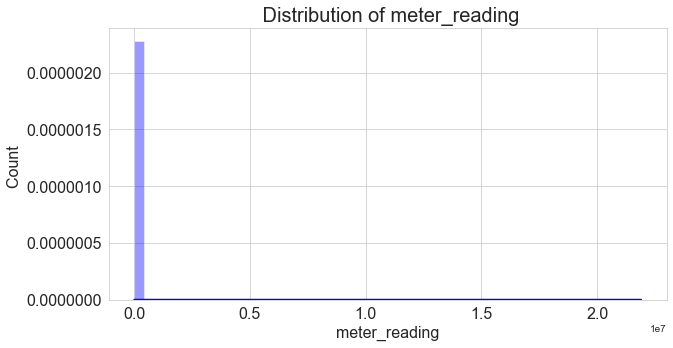

In [7]:
## target 变量：meter_reading 分析 
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (10, 5)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()
distplot(train['meter_reading'], 'blue')
    

**Distribution after log tranformation**

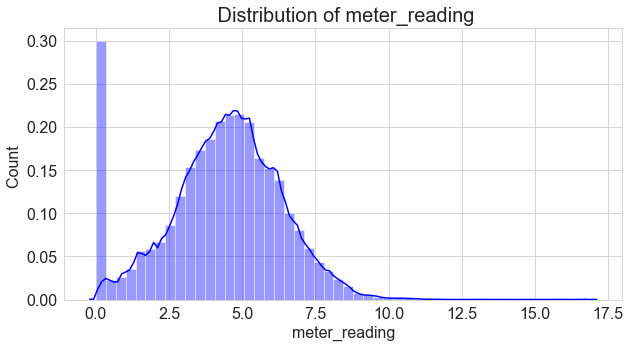

In [8]:
# meter_reading 变量严重偏移，尝试取对数修正
train['meter_reading'] = np.log1p(train['meter_reading'])

bold('**Distribution after log tranformation**')
distplot(train['meter_reading'], 'blue')

## 2、meter_reading 与meter_type分析

**电力是最频繁使用的meter_type**

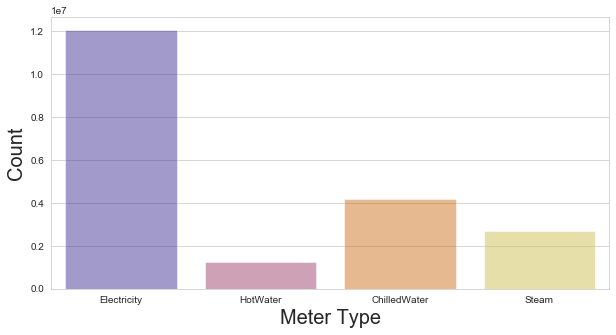

In [9]:
bold('**电力是最频繁使用的meter_type**')
plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.countplot(data = train, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Meter Type', fontsize = 20)
plt.show()

**stem 效率较差，electricity效率最高**

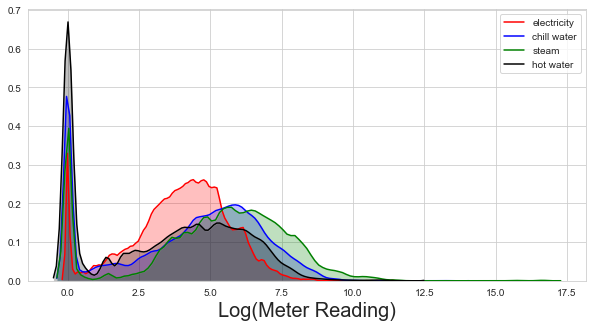

In [10]:
bold('**stem 效率较差，electricity效率最高**')
plt.rcParams['figure.figsize'] = (10, 5)

temp_df = train[train["meter"]=="Electricity"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="electricity", color='r')

temp_df = train[train["meter"]=="ChilledWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="chill water", color = 'b')

temp_df = train[train["meter"]=="Steam"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="steam", color = 'green')
temp_df = train[train["meter"]=="HotWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="hot water", color = 'k')
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
plt.show()

# weekday与meter_reading的关系

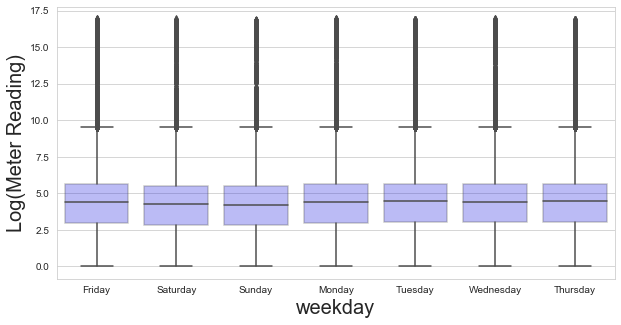

In [11]:
# bold('**weekday与meter_reading的关系**')
plt.rcParams['figure.figsize'] = (10, 5)
ax = sns.boxplot(data = train, x ='weekday_name', y = 'meter_reading', color = 'b', boxprops=dict(alpha=.3))
ax.set_ylabel('Log(Meter Reading)', fontsize = 20)
ax.set_xlabel('weekday', fontsize = 20)
plt.show()
# 周六 和周日meter_reading最低

**时间和meter_reading**

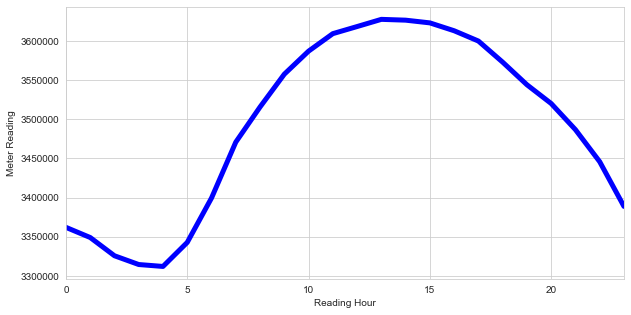

In [12]:
# 时间和meter_reading的关系

bold('**时间和meter_reading**')
plt.rcParams['figure.figsize'] = (10,5)
temp_df = train.groupby('hour').meter_reading.sum()
temp_df.plot(linewidth = 5, color = 'b')
plt.xlabel('Reading Hour', fontsize = 10)
plt.ylabel('Meter Reading')
plt.show()
# 时间和读书存在明显的周期性，晚上读数较低

# primary_use 与meter_reading的关系

**primary_use和 meter_reading**

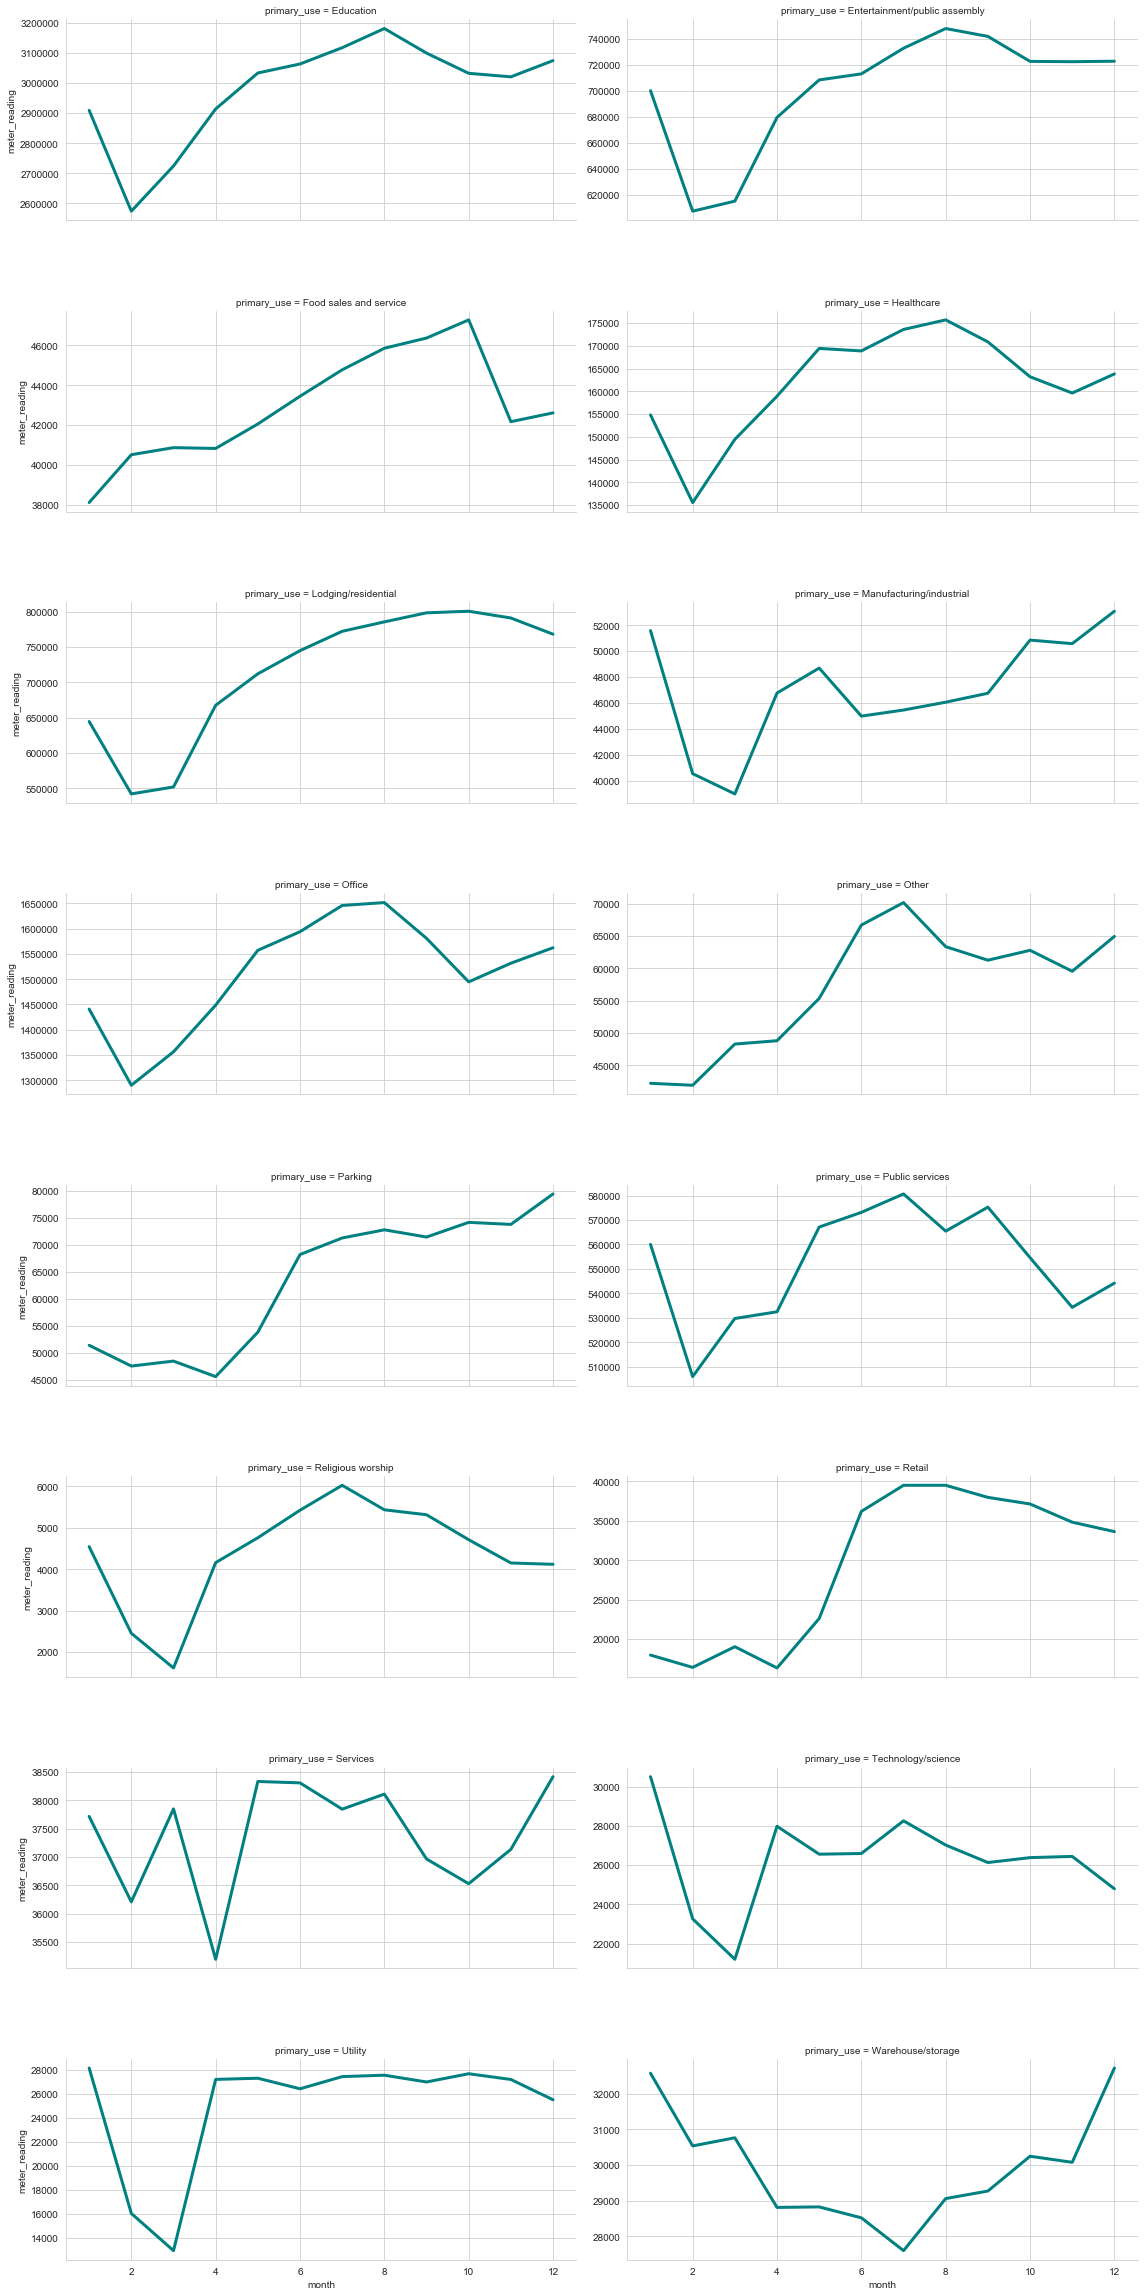

In [13]:
bold('**primary_use和 meter_reading**')
temp_df = train.groupby(['month', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

#按月的meter_reading 根据building type 变化较大

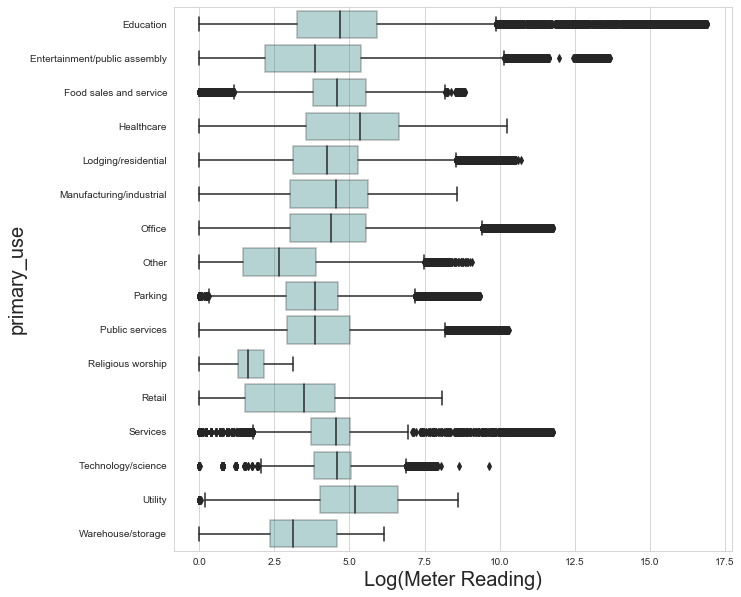

In [14]:
plt.rcParams['figure.figsize'] = (10, 10)
ax = sns.boxplot(data = train, y ='primary_use', x = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

# meter_reading 随着时间变化

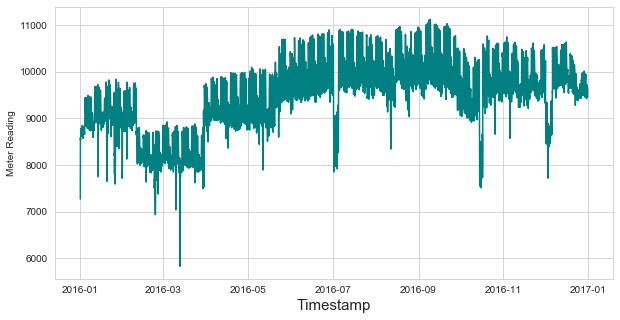

In [15]:

plt.rcParams['figure.figsize'] = (10,5)
temp_df = train.groupby(['timestamp', 'month']).meter_reading.sum().reset_index()
ax = sns.lineplot(data = temp_df, x = 'timestamp', y = 'meter_reading', color = 'teal')
plt.xlabel('Timestamp', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

#  协方差矩阵

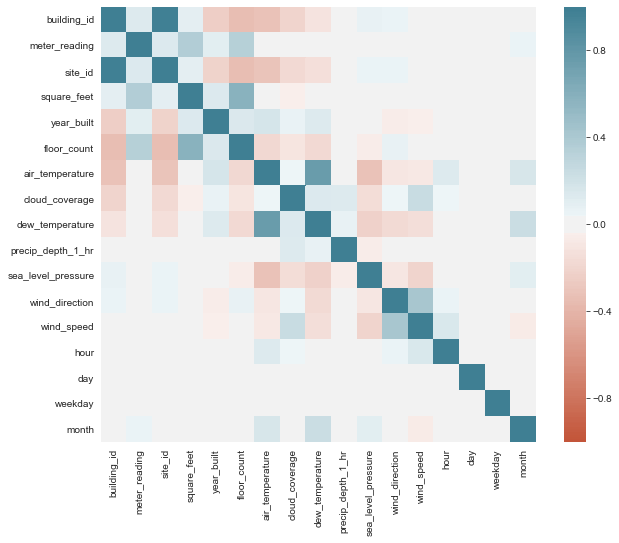

In [16]:
plt.rcParams['figure.figsize'] = (10,8)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

# square_feet

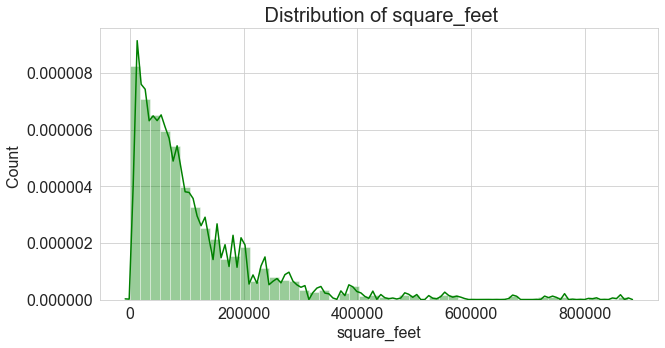

In [17]:
distplot(train['square_feet'], 'green')

**Distribution after log tranformation**

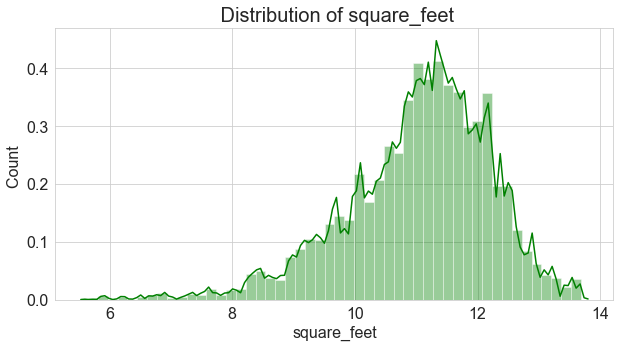

In [18]:
train['square_feet'] = np.log1p(train['square_feet'])
test['square_feet'] = np.log1p(test['square_feet'])

bold('**Distribution after log tranformation**')
distplot(train['square_feet'], 'green')

# year_built


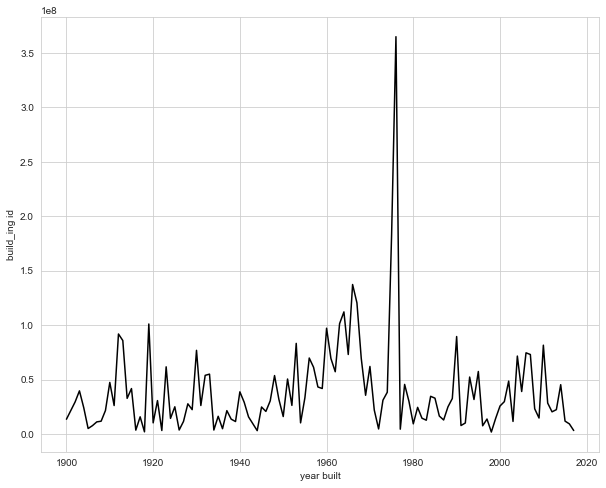

In [19]:
plt.rcParams['figure.figsize'] = (10, 8)
temp_df = train.groupby('year_built').building_id.sum().reset_index()
ax = sns.lineplot(data=temp_df, x='year_built', y='building_id', color = 'black')
plt.xlabel('year built')
plt.ylabel('build_ing id')
plt.show()

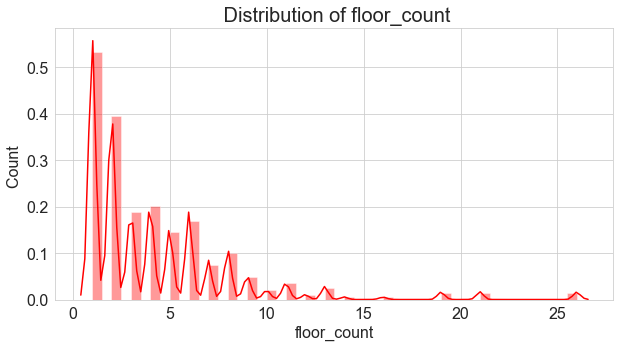

In [20]:
distplot(train['floor_count'].dropna(), 'red')

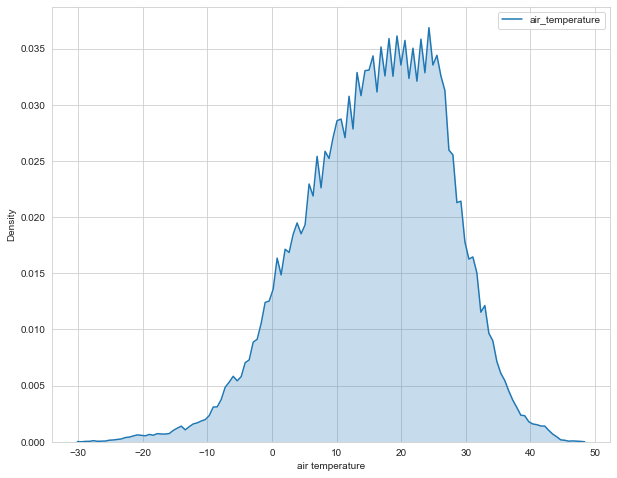

In [21]:
# air temperature
plt.rcParams['figure.figsize'] = (10, 8)

ax = sns.kdeplot(train['air_temperature'].dropna(), shade=True)

plt.xlabel('air temperature')
plt.ylabel('Density')
plt.show()


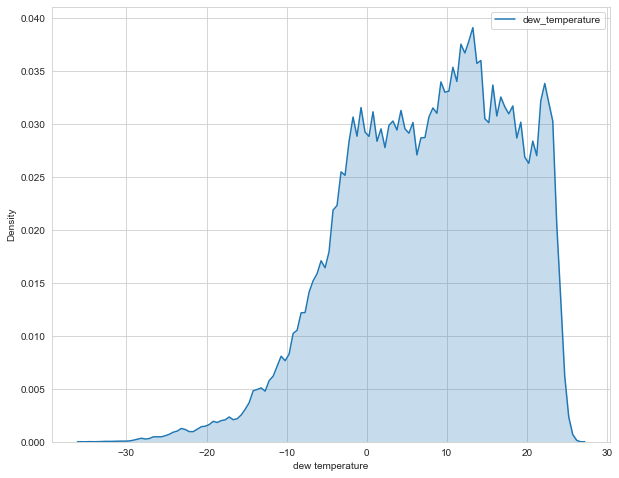

In [22]:
# Dew Temperature
plt.rcParams['figure.figsize'] = (10, 8)

ax = sns.kdeplot(train['dew_temperature'].dropna(), shade=True)
plt.xlabel('dew temperature')
plt.ylabel('Density')
plt.show()


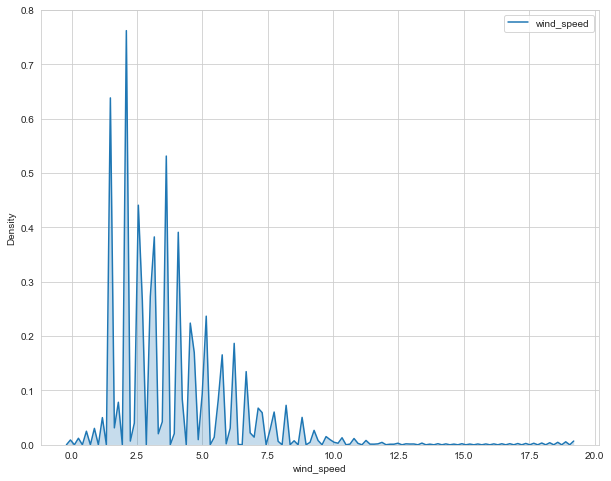

In [23]:
# 风速
plt.rcParams['figure.figsize'] = (10, 8)

ax = sns.kdeplot(train['wind_speed'].dropna(), shade=True)

plt.xlabel('wind_speed')
plt.ylabel('Density')
plt.show()

In [24]:
# wind direction & wind speed 
# 热力图中，风速和风向及其正相关

# TODO:


# ## 特征工程2


In [25]:
train['year_built'] = np.uint8(train['year_built']-1900, inplace = True)
test['year_built'] = np.uint8(test['year_built']-1900, inplace = True)


## Imputing Missing variabl  

'''The following variables are either discrete numerical or continuous numerical variables.So the will be imputed by median'''
to_impute_by_median = train.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    train[i].fillna(train[i].median(), inplace = True)

to_impute_by_median = test.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    test[i].fillna(test[i].median(), inplace = True)
##

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])
test['primary_use'] = le.fit_transform(test['primary_use'])

'''Now extract the nominal variables for one hot encoding of train and test data.'''
one_hot_train = pd.get_dummies(train['meter'])

one_hot_test = pd.get_dummies(test['meter'])

'''Droping variable'''
train.drop(columns=['meter', 'timestamp', 'weekday_name'], axis = 1, inplace = True)
test.drop(columns=['meter', 'timestamp'], axis = 1, inplace = True)

"""Let's concate one hot encoded, other variables together."""
train_processed = pd.concat([one_hot_train, train], axis = 1)
test_processed = pd.concat([one_hot_test, test], axis = 1)


In [26]:
bold('**Updated train data for modelling:**')
display(train_processed.head(3))
bold('**Updated test data for modelling:**')
display(test_processed.head(3))

**Updated train data for modelling:**

,ChilledWater,Electricity,HotWater,Steam,building_id,meter_reading,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,0,1,0,0,0,0.0,0,0,8.913685,108,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
1,0,1,0,0,1,0.0,0,0,7.908755,104,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
2,0,1,0,0,2,0.0,0,0,8.589886,91,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1


**Updated test data for modelling:**

,ChilledWater,Electricity,HotWater,Steam,row_id,building_id,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,0,1,0,0,0,0,0,0,8.913685,108,...,4.0,11.703125,0.0,1021.5,100.0,3.599609,0,1,6,1
1,0,1,0,0,1,1,0,0,7.908755,104,...,4.0,11.703125,0.0,1021.5,100.0,3.599609,0,1,6,1
2,0,1,0,0,2,2,0,0,8.589886,91,...,4.0,11.703125,0.0,1021.5,100.0,3.599609,0,1,6,1


# base line

In [27]:
target = train_processed['meter_reading']
train= train_processed.drop(['meter_reading'], axis=1)

test = test_processed.drop(['row_id'], axis=1)

bold('**模型训练的数据尺寸:**')
print('Input matrix dimension:', train.shape)
print('Output vector dimension:',target.shape)
print('Test data dimension:', test.shape)


**模型训练的数据尺寸:**

Input matrix dimension: (20216100, 21)
Output vector dimension: (20216100,)
Test data dimension: (41697600, 21)


In [28]:
cat_feat = ['ChilledWater', 'Electricity', 'HotWater', 'Steam',"site_id", "building_id", "primary_use", "hour", "weekday", "wind_direction"]

In [62]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 4
seed = 55
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
# oof_pred = np.zeros(train.shape[0])  # out of fold predictions
models = []

## stratify data by building_id
for train_index, val_index in tqdm(kf.split(train, train['building_id']), total=folds):
    train_X = train.iloc[train_index]
    val_X = train.iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=cat_feat)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=cat_feat)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)




  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\bai\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.907263	valid_1's rmse: 0.908662
[200]	training's rmse: 0.836314	valid_1's rmse: 0.837742
[300]	training's rmse: 0.800572	valid_1's rmse: 0.802529
[400]	training's rmse: 0.779682	valid_1's rmse: 0.782227
[500]	training's rmse: 0.760857	valid_1's rmse: 0.763871
[600]	training's rmse: 0.74772	valid_1's rmse: 0.751395
[700]	training's rmse: 0.734688	valid_1's rmse: 0.739138
[800]	training's rmse: 0.725774	valid_1's rmse: 0.730879
[900]	training's rmse: 0.717285	valid_1's rmse: 0.723072
[1000]	training's rmse: 0.710449	valid_1's rmse: 0.716684
[1100]	training's rmse: 0.703429	valid_1's rmse: 0.710224
[1200]	training's rmse: 0.697605	valid_1's rmse: 0.70493
[1300]	training's rmse: 0.693072	valid_1's rmse: 0.700961
[1400]	training's rmse: 0.689375	valid_1's rmse: 0.697952
[1500]	training's rmse: 0.684362	valid_1's rmse: 0.693517
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.68436




 25%|██▌       | 1/4 [13:34<40:44, 814.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.912714	valid_1's rmse: 0.912156
[200]	training's rmse: 0.841828	valid_1's rmse: 0.84132
[300]	training's rmse: 0.803538	valid_1's rmse: 0.803676
[400]	training's rmse: 0.78118	valid_1's rmse: 0.78182
[500]	training's rmse: 0.757316	valid_1's rmse: 0.758676
[600]	training's rmse: 0.746696	valid_1's rmse: 0.748725
[700]	training's rmse: 0.736441	valid_1's rmse: 0.739117
[800]	training's rmse: 0.727543	valid_1's rmse: 0.730795
[900]	training's rmse: 0.718211	valid_1's rmse: 0.722055
[1000]	training's rmse: 0.710865	valid_1's rmse: 0.715386
[1100]	training's rmse: 0.703456	valid_1's rmse: 0.70862
[1200]	training's rmse: 0.697445	valid_1's rmse: 0.703282
[1300]	training's rmse: 0.69282	valid_1's rmse: 0.699346
[1400]	training's rmse: 0.688925	valid_1's rmse: 0.696088
[1500]	training's rmse: 0.685372	valid_1's rmse: 0.693048
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.685372	v




 50%|█████     | 2/4 [21:19<23:39, 709.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.905041	valid_1's rmse: 0.906516
[200]	training's rmse: 0.836071	valid_1's rmse: 0.838129
[300]	training's rmse: 0.798806	valid_1's rmse: 0.801568
[400]	training's rmse: 0.775253	valid_1's rmse: 0.77831
[500]	training's rmse: 0.755073	valid_1's rmse: 0.758594
[600]	training's rmse: 0.743832	valid_1's rmse: 0.747916
[700]	training's rmse: 0.732878	valid_1's rmse: 0.73764
[800]	training's rmse: 0.724496	valid_1's rmse: 0.730027
[900]	training's rmse: 0.715437	valid_1's rmse: 0.721555
[1000]	training's rmse: 0.709036	valid_1's rmse: 0.715784
[1100]	training's rmse: 0.702018	valid_1's rmse: 0.709355
[1200]	training's rmse: 0.697701	valid_1's rmse: 0.705715
[1300]	training's rmse: 0.693156	valid_1's rmse: 0.701768
[1400]	training's rmse: 0.689806	valid_1's rmse: 0.699019
[1500]	training's rmse: 0.685468	valid_1's rmse: 0.695259
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.68546




 75%|███████▌  | 3/4 [29:13<10:39, 639.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.914909	valid_1's rmse: 0.915953
[200]	training's rmse: 0.853612	valid_1's rmse: 0.854974
[300]	training's rmse: 0.811956	valid_1's rmse: 0.81371
[400]	training's rmse: 0.789861	valid_1's rmse: 0.792153
[500]	training's rmse: 0.765913	valid_1's rmse: 0.769073
[600]	training's rmse: 0.749774	valid_1's rmse: 0.753598
[700]	training's rmse: 0.738038	valid_1's rmse: 0.742429
[800]	training's rmse: 0.727849	valid_1's rmse: 0.732703
[900]	training's rmse: 0.719324	valid_1's rmse: 0.724701
[1000]	training's rmse: 0.710023	valid_1's rmse: 0.715999
[1100]	training's rmse: 0.701873	valid_1's rmse: 0.708514
[1200]	training's rmse: 0.696852	valid_1's rmse: 0.70417
[1300]	training's rmse: 0.692129	valid_1's rmse: 0.700064
[1400]	training's rmse: 0.688057	valid_1's rmse: 0.69665
[1500]	training's rmse: 0.684018	valid_1's rmse: 0.693165
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.684018




100%|██████████| 4/4 [36:44<00:00, 582.62s/it]

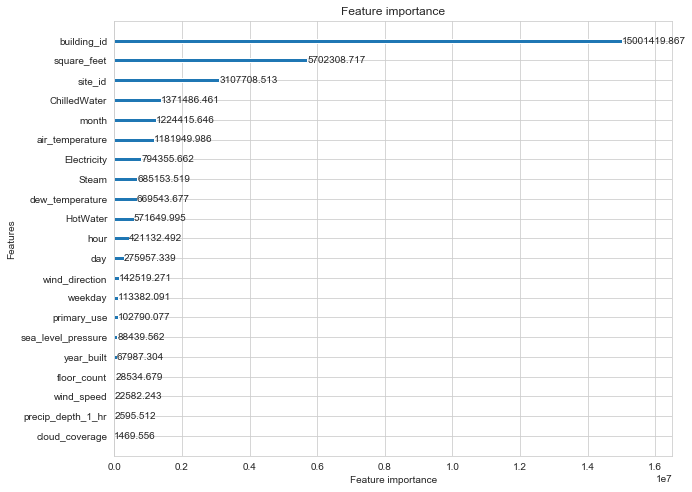

In [63]:
plt.rcParams['figure.figsize'] = (10,8)
lgb.plot_importance(models[0], importance_type='gain')
plt.show()

In [64]:
# 预测和提交

result=[]
step_size = 200000
print(test.shape[0], np.ceil(test.shape[0]/200000))
      
for j in tqdm(range(int(np.ceil(test.shape[0]/200000)))):
    end = (j+1)*step_size
    start = j* step_size
    if end >= test.shape[0]:
        end = test.shape[0]
    print(start, end)
    temp= [model.predict(test.iloc[start:end]) for model in models]
    result.append(np.expm1(sum(temp)/folds))

    
'''Submission'''
result = np.concatenate(result)


41697600 209.0





  0%|          | 0/209 [00:00<?, ?it/s]

0 200000





  0%|          | 1/209 [00:10<37:25, 10.80s/it]

200000 400000





  1%|          | 2/209 [00:21<37:14, 10.80s/it]

400000 600000





  1%|▏         | 3/209 [00:32<37:22, 10.88s/it]

600000 800000





  2%|▏         | 4/209 [00:43<37:04, 10.85s/it]

800000 1000000





  2%|▏         | 5/209 [00:54<36:52, 10.85s/it]

1000000 1200000





  3%|▎         | 6/209 [01:05<37:24, 11.06s/it]

1200000 1400000





  3%|▎         | 7/209 [01:17<37:23, 11.11s/it]

1400000 1600000





  4%|▍         | 8/209 [01:28<37:24, 11.17s/it]

1600000 1800000





  4%|▍         | 9/209 [01:39<37:20, 11.20s/it]

1800000 2000000





  5%|▍         | 10/209 [01:50<37:07, 11.19s/it]

2000000 2200000





  5%|▌         | 11/209 [02:01<36:54, 11.18s/it]

2200000 2400000





  6%|▌         | 12/209 [02:13<36:36, 11.15s/it]

2400000 2600000





  6%|▌         | 13/209 [02:24<36:26, 11.15s/it]

2600000 2800000





  7%|▋         | 14/209 [02:35<36:12, 11.14s/it]

2800000 3000000





  7%|▋         | 15/209 [02:46<35:46, 11.06s/it]

3000000 3200000





  8%|▊         | 16/209 [02:57<35:29, 11.03s/it]

3200000 3400000





  8%|▊         | 17/209 [03:08<35:27, 11.08s/it]

3400000 3600000





  9%|▊         | 18/209 [03:19<35:45, 11.23s/it]

3600000 3800000





  9%|▉         | 19/209 [03:31<36:11, 11.43s/it]

3800000 4000000





 10%|▉         | 20/209 [03:43<36:03, 11.44s/it]

4000000 4200000





 10%|█         | 21/209 [03:56<37:45, 12.05s/it]

4200000 4400000





 11%|█         | 22/209 [04:09<38:24, 12.32s/it]

4400000 4600000





 11%|█         | 23/209 [04:21<37:36, 12.13s/it]

4600000 4800000





 11%|█▏        | 24/209 [04:32<36:35, 11.87s/it]

4800000 5000000





 12%|█▏        | 25/209 [04:42<34:49, 11.36s/it]

5000000 5200000





 12%|█▏        | 26/209 [04:53<33:33, 11.00s/it]

5200000 5400000





 13%|█▎        | 27/209 [05:03<32:33, 10.73s/it]

5400000 5600000





 13%|█▎        | 28/209 [05:13<32:04, 10.63s/it]

5600000 5800000





 14%|█▍        | 29/209 [05:23<31:25, 10.48s/it]

5800000 6000000





 14%|█▍        | 30/209 [05:33<30:34, 10.25s/it]

6000000 6200000





 15%|█▍        | 31/209 [05:43<29:52, 10.07s/it]

6200000 6400000





 15%|█▌        | 32/209 [05:53<30:20, 10.29s/it]

6400000 6600000





 16%|█▌        | 33/209 [06:03<30:02, 10.24s/it]

6600000 6800000





 16%|█▋        | 34/209 [06:14<29:46, 10.21s/it]

6800000 7000000





 17%|█▋        | 35/209 [06:24<29:35, 10.20s/it]

7000000 7200000





 17%|█▋        | 36/209 [06:34<29:13, 10.14s/it]

7200000 7400000





 18%|█▊        | 37/209 [06:44<29:04, 10.14s/it]

7400000 7600000





 18%|█▊        | 38/209 [06:54<28:48, 10.11s/it]

7600000 7800000





 19%|█▊        | 39/209 [07:04<29:00, 10.24s/it]

7800000 8000000





 19%|█▉        | 40/209 [07:16<29:37, 10.52s/it]

8000000 8200000





 20%|█▉        | 41/209 [07:28<30:35, 10.93s/it]

8200000 8400000





 20%|██        | 42/209 [07:39<30:35, 10.99s/it]

8400000 8600000





 21%|██        | 43/209 [07:50<31:05, 11.24s/it]

8600000 8800000





 21%|██        | 44/209 [08:02<31:09, 11.33s/it]

8800000 9000000





 22%|██▏       | 45/209 [08:13<30:39, 11.22s/it]

9000000 9200000





 22%|██▏       | 46/209 [08:24<30:42, 11.30s/it]

9200000 9400000





 22%|██▏       | 47/209 [08:36<30:31, 11.31s/it]

9400000 9600000





 23%|██▎       | 48/209 [08:47<30:22, 11.32s/it]

9600000 9800000





 23%|██▎       | 49/209 [08:58<30:02, 11.26s/it]

9800000 10000000





 24%|██▍       | 50/209 [09:09<29:42, 11.21s/it]

10000000 10200000





 24%|██▍       | 51/209 [09:20<29:26, 11.18s/it]

10200000 10400000





 25%|██▍       | 52/209 [09:31<28:50, 11.02s/it]

10400000 10600000





 25%|██▌       | 53/209 [09:42<28:49, 11.09s/it]

10600000 10800000





 26%|██▌       | 54/209 [09:54<28:52, 11.18s/it]

10800000 11000000





 26%|██▋       | 55/209 [10:05<28:41, 11.18s/it]

11000000 11200000





 27%|██▋       | 56/209 [10:16<28:40, 11.25s/it]

11200000 11400000





 27%|██▋       | 57/209 [10:28<28:51, 11.39s/it]

11400000 11600000





 28%|██▊       | 58/209 [10:40<28:49, 11.45s/it]

11600000 11800000





 28%|██▊       | 59/209 [10:51<28:31, 11.41s/it]

11800000 12000000





 29%|██▊       | 60/209 [11:02<28:05, 11.31s/it]

12000000 12200000





 29%|██▉       | 61/209 [11:14<28:06, 11.40s/it]

12200000 12400000





 30%|██▉       | 62/209 [11:25<27:32, 11.24s/it]

12400000 12600000





 30%|███       | 63/209 [11:35<26:58, 11.08s/it]

12600000 12800000





 31%|███       | 64/209 [11:46<26:42, 11.05s/it]

12800000 13000000





 31%|███       | 65/209 [11:57<26:09, 10.90s/it]

13000000 13200000





 32%|███▏      | 66/209 [12:08<26:09, 10.97s/it]

13200000 13400000





 32%|███▏      | 67/209 [12:19<25:43, 10.87s/it]

13400000 13600000





 33%|███▎      | 68/209 [12:30<25:37, 10.91s/it]

13600000 13800000





 33%|███▎      | 69/209 [12:40<25:24, 10.89s/it]

13800000 14000000





 33%|███▎      | 70/209 [12:51<25:18, 10.92s/it]

14000000 14200000





 34%|███▍      | 71/209 [13:02<24:47, 10.78s/it]

14200000 14400000





 34%|███▍      | 72/209 [13:12<24:08, 10.57s/it]

14400000 14600000





 35%|███▍      | 73/209 [13:23<24:14, 10.70s/it]

14600000 14800000





 35%|███▌      | 74/209 [13:33<24:00, 10.67s/it]

14800000 15000000





 36%|███▌      | 75/209 [13:45<24:27, 10.95s/it]

15000000 15200000





 36%|███▋      | 76/209 [13:57<24:38, 11.12s/it]

15200000 15400000





 37%|███▋      | 77/209 [14:08<24:40, 11.21s/it]

15400000 15600000





 37%|███▋      | 78/209 [14:19<24:34, 11.25s/it]

15600000 15800000





 38%|███▊      | 79/209 [14:31<24:40, 11.39s/it]

15800000 16000000





 38%|███▊      | 80/209 [14:43<24:37, 11.45s/it]

16000000 16200000





 39%|███▉      | 81/209 [14:54<24:27, 11.46s/it]

16200000 16400000





 39%|███▉      | 82/209 [15:05<23:58, 11.33s/it]

16400000 16600000





 40%|███▉      | 83/209 [15:17<24:14, 11.54s/it]

16600000 16800000





 40%|████      | 84/209 [15:29<23:57, 11.50s/it]

16800000 17000000





 41%|████      | 85/209 [15:40<23:44, 11.49s/it]

17000000 17200000





 41%|████      | 86/209 [15:52<23:48, 11.62s/it]

17200000 17400000





 42%|████▏     | 87/209 [16:04<23:34, 11.59s/it]

17400000 17600000





 42%|████▏     | 88/209 [16:15<23:27, 11.63s/it]

17600000 17800000





 43%|████▎     | 89/209 [16:27<23:23, 11.69s/it]

17800000 18000000





 43%|████▎     | 90/209 [16:39<23:09, 11.68s/it]

18000000 18200000





 44%|████▎     | 91/209 [16:51<23:25, 11.91s/it]

18200000 18400000





 44%|████▍     | 92/209 [17:03<23:17, 11.94s/it]

18400000 18600000





 44%|████▍     | 93/209 [17:15<22:44, 11.77s/it]

18600000 18800000





 45%|████▍     | 94/209 [17:26<22:38, 11.81s/it]

18800000 19000000





 45%|████▌     | 95/209 [17:38<22:15, 11.71s/it]

19000000 19200000





 46%|████▌     | 96/209 [17:49<21:46, 11.56s/it]

19200000 19400000





 46%|████▋     | 97/209 [18:01<21:29, 11.51s/it]

19400000 19600000





 47%|████▋     | 98/209 [18:12<21:14, 11.48s/it]

19600000 19800000





 47%|████▋     | 99/209 [18:23<20:50, 11.37s/it]

19800000 20000000





 48%|████▊     | 100/209 [18:34<20:12, 11.12s/it]

20000000 20200000





 48%|████▊     | 101/209 [18:45<19:55, 11.07s/it]

20200000 20400000





 49%|████▉     | 102/209 [18:56<19:48, 11.11s/it]

20400000 20600000





 49%|████▉     | 103/209 [19:07<19:30, 11.04s/it]

20600000 20800000





 50%|████▉     | 104/209 [19:18<19:19, 11.04s/it]

20800000 21000000





 50%|█████     | 105/209 [19:29<19:11, 11.07s/it]

21000000 21200000





 51%|█████     | 106/209 [19:40<19:13, 11.20s/it]

21200000 21400000





 51%|█████     | 107/209 [19:51<18:50, 11.08s/it]

21400000 21600000





 52%|█████▏    | 108/209 [20:02<18:21, 10.90s/it]

21600000 21800000





 52%|█████▏    | 109/209 [20:13<18:24, 11.04s/it]

21800000 22000000





 53%|█████▎    | 110/209 [20:23<17:44, 10.75s/it]

22000000 22200000





 53%|█████▎    | 111/209 [20:33<17:16, 10.58s/it]

22200000 22400000





 54%|█████▎    | 112/209 [20:44<17:03, 10.55s/it]

22400000 22600000





 54%|█████▍    | 113/209 [20:54<16:45, 10.47s/it]

22600000 22800000





 55%|█████▍    | 114/209 [21:04<16:13, 10.24s/it]

22800000 23000000





 55%|█████▌    | 115/209 [21:13<15:47, 10.08s/it]

23000000 23200000





 56%|█████▌    | 116/209 [21:23<15:30, 10.00s/it]

23200000 23400000





 56%|█████▌    | 117/209 [21:33<15:08,  9.87s/it]

23400000 23600000





 56%|█████▋    | 118/209 [21:43<14:55,  9.84s/it]

23600000 23800000





 57%|█████▋    | 119/209 [21:52<14:44,  9.83s/it]

23800000 24000000





 57%|█████▋    | 120/209 [22:02<14:31,  9.79s/it]

24000000 24200000





 58%|█████▊    | 121/209 [22:12<14:20,  9.78s/it]

24200000 24400000





 58%|█████▊    | 122/209 [22:22<14:07,  9.74s/it]

24400000 24600000





 59%|█████▉    | 123/209 [22:31<13:56,  9.73s/it]

24600000 24800000





 59%|█████▉    | 124/209 [22:41<13:45,  9.71s/it]

24800000 25000000





 60%|█████▉    | 125/209 [22:51<13:34,  9.69s/it]

25000000 25200000





 60%|██████    | 126/209 [23:00<13:28,  9.74s/it]

25200000 25400000





 61%|██████    | 127/209 [23:10<13:19,  9.74s/it]

25400000 25600000





 61%|██████    | 128/209 [23:20<13:10,  9.76s/it]

25600000 25800000





 62%|██████▏   | 129/209 [23:30<13:02,  9.78s/it]

25800000 26000000





 62%|██████▏   | 130/209 [23:40<12:55,  9.82s/it]

26000000 26200000





 63%|██████▎   | 131/209 [23:49<12:45,  9.81s/it]

26200000 26400000





 63%|██████▎   | 132/209 [24:00<12:40,  9.88s/it]

26400000 26600000





 64%|██████▎   | 133/209 [24:09<12:27,  9.84s/it]

26600000 26800000





 64%|██████▍   | 134/209 [24:19<12:14,  9.80s/it]

26800000 27000000





 65%|██████▍   | 135/209 [24:29<12:03,  9.78s/it]

27000000 27200000





 65%|██████▌   | 136/209 [24:38<11:50,  9.74s/it]

27200000 27400000





 66%|██████▌   | 137/209 [24:48<11:41,  9.75s/it]

27400000 27600000





 66%|██████▌   | 138/209 [24:58<11:28,  9.70s/it]

27600000 27800000





 67%|██████▋   | 139/209 [25:07<11:19,  9.71s/it]

27800000 28000000





 67%|██████▋   | 140/209 [25:17<11:06,  9.66s/it]

28000000 28200000





 67%|██████▋   | 141/209 [25:27<10:56,  9.66s/it]

28200000 28400000





 68%|██████▊   | 142/209 [25:36<10:47,  9.67s/it]

28400000 28600000





 68%|██████▊   | 143/209 [25:46<10:38,  9.68s/it]

28600000 28800000





 69%|██████▉   | 144/209 [25:56<10:33,  9.74s/it]

28800000 29000000





 69%|██████▉   | 145/209 [26:06<10:20,  9.70s/it]

29000000 29200000





 70%|██████▉   | 146/209 [26:15<10:11,  9.70s/it]

29200000 29400000





 70%|███████   | 147/209 [26:25<10:01,  9.69s/it]

29400000 29600000





 71%|███████   | 148/209 [26:35<09:52,  9.72s/it]

29600000 29800000





 71%|███████▏  | 149/209 [26:44<09:43,  9.73s/it]

29800000 30000000





 72%|███████▏  | 150/209 [26:54<09:33,  9.71s/it]

30000000 30200000





 72%|███████▏  | 151/209 [27:04<09:26,  9.77s/it]

30200000 30400000





 73%|███████▎  | 152/209 [27:14<09:15,  9.75s/it]

30400000 30600000





 73%|███████▎  | 153/209 [27:23<09:02,  9.69s/it]

30600000 30800000





 74%|███████▎  | 154/209 [27:33<08:54,  9.72s/it]

30800000 31000000





 74%|███████▍  | 155/209 [27:43<08:43,  9.70s/it]

31000000 31200000





 75%|███████▍  | 156/209 [27:52<08:33,  9.68s/it]

31200000 31400000





 75%|███████▌  | 157/209 [28:02<08:23,  9.69s/it]

31400000 31600000





 76%|███████▌  | 158/209 [28:12<08:14,  9.69s/it]

31600000 31800000





 76%|███████▌  | 159/209 [28:21<08:04,  9.70s/it]

31800000 32000000





 77%|███████▋  | 160/209 [28:31<07:56,  9.72s/it]

32000000 32200000





 77%|███████▋  | 161/209 [28:41<07:46,  9.72s/it]

32200000 32400000





 78%|███████▊  | 162/209 [28:51<07:39,  9.77s/it]

32400000 32600000





 78%|███████▊  | 163/209 [29:01<07:28,  9.75s/it]

32600000 32800000





 78%|███████▊  | 164/209 [29:10<07:19,  9.78s/it]

32800000 33000000





 79%|███████▉  | 165/209 [29:20<07:11,  9.80s/it]

33000000 33200000





 79%|███████▉  | 166/209 [29:30<06:59,  9.74s/it]

33200000 33400000





 80%|███████▉  | 167/209 [29:40<06:49,  9.75s/it]

33400000 33600000





 80%|████████  | 168/209 [29:49<06:39,  9.75s/it]

33600000 33800000





 81%|████████  | 169/209 [29:59<06:29,  9.74s/it]

33800000 34000000





 81%|████████▏ | 170/209 [30:09<06:22,  9.80s/it]

34000000 34200000





 82%|████████▏ | 171/209 [30:19<06:19,  9.98s/it]

34200000 34400000





 82%|████████▏ | 172/209 [30:30<06:13, 10.09s/it]

34400000 34600000





 83%|████████▎ | 173/209 [30:40<06:03, 10.10s/it]

34600000 34800000





 83%|████████▎ | 174/209 [30:50<05:55, 10.15s/it]

34800000 35000000





 84%|████████▎ | 175/209 [31:00<05:43, 10.09s/it]

35000000 35200000





 84%|████████▍ | 176/209 [31:10<05:29,  9.99s/it]

35200000 35400000





 85%|████████▍ | 177/209 [31:20<05:17,  9.93s/it]

35400000 35600000





 85%|████████▌ | 178/209 [31:29<05:07,  9.91s/it]

35600000 35800000





 86%|████████▌ | 179/209 [31:39<04:57,  9.91s/it]

35800000 36000000





 86%|████████▌ | 180/209 [31:49<04:46,  9.86s/it]

36000000 36200000





 87%|████████▋ | 181/209 [31:59<04:35,  9.85s/it]

36200000 36400000





 87%|████████▋ | 182/209 [32:09<04:24,  9.81s/it]

36400000 36600000





 88%|████████▊ | 183/209 [32:18<04:14,  9.78s/it]

36600000 36800000





 88%|████████▊ | 184/209 [32:28<04:04,  9.77s/it]

36800000 37000000





 89%|████████▊ | 185/209 [32:38<03:54,  9.78s/it]

37000000 37200000





 89%|████████▉ | 186/209 [32:48<03:45,  9.82s/it]

37200000 37400000





 89%|████████▉ | 187/209 [32:58<03:36,  9.83s/it]

37400000 37600000





 90%|████████▉ | 188/209 [33:08<03:26,  9.84s/it]

37600000 37800000





 90%|█████████ | 189/209 [33:17<03:16,  9.82s/it]

37800000 38000000





 91%|█████████ | 190/209 [33:27<03:06,  9.82s/it]

38000000 38200000





 91%|█████████▏| 191/209 [33:37<02:56,  9.82s/it]

38200000 38400000





 92%|█████████▏| 192/209 [33:47<02:46,  9.81s/it]

38400000 38600000





 92%|█████████▏| 193/209 [33:57<02:37,  9.86s/it]

38600000 38800000





 93%|█████████▎| 194/209 [34:07<02:27,  9.83s/it]

38800000 39000000





 93%|█████████▎| 195/209 [34:16<02:17,  9.85s/it]

39000000 39200000





 94%|█████████▍| 196/209 [34:26<02:08,  9.86s/it]

39200000 39400000





 94%|█████████▍| 197/209 [34:36<01:58,  9.90s/it]

39400000 39600000





 95%|█████████▍| 198/209 [34:46<01:48,  9.90s/it]

39600000 39800000





 95%|█████████▌| 199/209 [34:56<01:38,  9.90s/it]

39800000 40000000





 96%|█████████▌| 200/209 [35:06<01:28,  9.88s/it]

40000000 40200000





 96%|█████████▌| 201/209 [35:16<01:19,  9.96s/it]

40200000 40400000





 97%|█████████▋| 202/209 [35:26<01:09,  9.91s/it]

40400000 40600000





 97%|█████████▋| 203/209 [35:36<00:59,  9.90s/it]

40600000 40800000





 98%|█████████▊| 204/209 [35:46<00:49,  9.96s/it]

40800000 41000000





 98%|█████████▊| 205/209 [35:56<00:39,  9.97s/it]

41000000 41200000





 99%|█████████▊| 206/209 [36:06<00:29,  9.94s/it]

41200000 41400000





 99%|█████████▉| 207/209 [36:16<00:19,  9.97s/it]

41400000 41600000





100%|█████████▉| 208/209 [36:25<00:09,  9.89s/it]

41600000 41697600





100%|██████████| 209/209 [36:30<00:00,  8.40s/it]

In [65]:
# del train
# gc.collect()

# result = np.concatenate(result)
submission = pd.read_csv("./data/sample_submission.csv")
print("reault 大小 ：", result.shape)
print("test 大小: ", test.shape)
print("submission 大小", submission.shape)
bold("**submission:**")
display(submission.head(3))

# #submission.drop([0])
# submission.head(5)
# #submission
# #print(result.shape)


submission['meter_reading'] = result
submission.to_csv("./submission.csv", index = False)


reault 大小 ： (41697600,)
test 大小:  (41697600, 21)
submission 大小 (41697600, 2)


**submission:**

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
